# Data Analysis and Fitting
# Lag Estimate Statistics
Below we will explore the statistical properties of the lags estimated from voltage samples. We will work towards an understanding of the variance of the lag products, which is needed to fit ISR data. Recall that when we perform least-squares fitting, we want to include the covariance matrix of the data to weight the fit:

$\chi^2(\mathbf{p}) =\left[\mathbf{z}-f(\mathbf{p})\right]^T \mathbf{\Sigma_e}^{-1} \left[\mathbf{z}-f(\mathbf{p})\right]$

where $\mathbf{\Sigma}_e$ is the covariance matrix of the data, $\mathbf{z}$, assuming the measurement errors are Gaussian distributed. In this notebook, we use Monte Carlo to demonstrate that the lag product estimates are indeed Gaussian distributed so long as a sufficient number of samples are taken.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot
import numpy as np
import corner
font = {'size'   : 18}
matplotlib.rc('font', **font)
# set the random seed; get the same results each time we run this notebook
seed = sum([ord(x) for x in 'isrschool'])
np.random.seed(seed)

## Voltage Samples
As discussed in a previous lecture, an estimate of the lag product, $\hat{L}^i_{\ell}$, at a particular range $i$ and lag $\ell$ is estimated from voltage samples, $V_i$, measured by the radar:

$\hat{L}^i_{\ell} = \frac{1}{K}\sum^{K-1}_{k=0}V^*_{i}V_{i+\ell}$

where $K$ is the number of samples. In practice, different pulse coding schemes provide different ways to estimate each lag product, but for what follows, we don't need to know those particular details. We seek to understand the statistical properties of $\hat{L}^i_{\ell}$ given that the complex voltage samples:

$ V_{i} = x_1 + j x_2 \quad V_{i+\ell} = x_3 + j x_4 $

are described by a multivariate Gaussian probability distribution function (PDF):



$p(x_1,x_2,x_3,x_4) = \frac{1}{(2\pi)^2|\mathbf{C}|^{1/2}}\exp{\left(\frac{-1}{2|\mathbf{C}|}\sum^4_{i,j=1}C_{ij}x_i x_j \right)}$

with covariance:

$ \mathbf{C} = \sigma^2\begin{pmatrix}
1       & 0      & \rho_r & -\rho_i \\
0       & 1      & \rho_i & \rho_r \\
\rho_r  & \rho_i & 1      & 0 \\
-\rho_i & \rho_r & 0      & 1 \\
\end{pmatrix}$

It was stated that $\hat{L}^i_{\ell}$ will be a Gaussian random variable for large $K$ (using the Central Limit Theorem). We can show this to be true using Monte Carlo.

First, we'll create an ensemble of voltage samples for $V^*_{i}$ and $V_{i+\ell}$, which we will call $V_1$ and $V_2$, for simplicity.

We will use the relationship between the power and variance of the voltage samples, $P=2\sigma^2$:

In [2]:
P = 1
variance = P/2.
p = 0.8
pr = 0.3
pi = np.sqrt(p**2-pr**2)

def get_voltage_sample_ensemble(samples=(50000,)):
    c = (P/2.)*np.array([[1,0,pr,-pi],[0,1,pi,pr],[pr,pi,1,0],[-pi,pr,0,1]])
    m = np.zeros(4)
    sample_ensemble = np.random.multivariate_normal(m,c,size=samples)

    return sample_ensemble

temp = get_voltage_sample_ensemble()
voltage1 = np.array([x[0]+1j*x[1] for x in temp])
voltage2 = np.array([x[2]+1j*x[3] for x in temp])

Now, for the ensembles of $V_1$ and $V_2$, we can calculate an ensemble of lag estimates, $\hat{L}^i_{\ell}$ and then we can plot a histogram of this ensemble to see how the lag estimate is distributed. To keep it simple, let's start with $\hat{L}^i_{\ell}$ for $K=1$ and plot the distribution of the real and imaginary components:

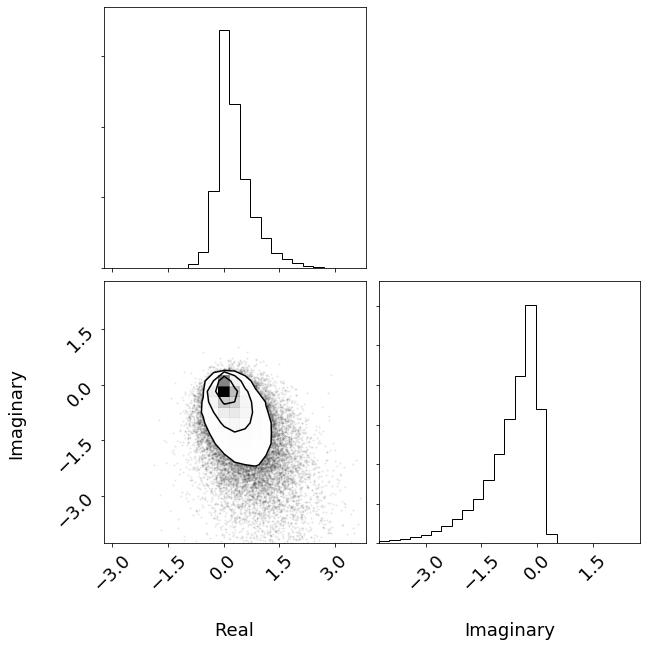

In [3]:
lag_estimate = np.conj(voltage1)*voltage2

K=1
lim = 5*np.sqrt(variance/K)
lims = np.array([[P*pr-lim,P*pr+lim],[-P*pi-lim,-P*pi+lim]])
fig = pyplot.figure(figsize=(10,10))
ax = fig.add_subplot(221)
ax = fig.add_subplot(222)
ax = fig.add_subplot(223)
ax = fig.add_subplot(224)
tmp = corner.corner(np.array([lag_estimate.real,lag_estimate.imag]).T,bins=25,
                    range=lims,labels=['Real','Imaginary'],fig=fig)

Now, how does the distribution of the ensemble of $\hat{L}^i_{\ell}$ change for $K=5$? $K=10$? $K=50$? Change $K$ and see how the distribution changes.

In [4]:
# note that increasing K makes the code run slower K=50 could a minute or two
K=50

def get_lag_estimate_ensemble(K):
    temp = get_voltage_sample_ensemble(P,p,pr,pi,samples=(50000,K))
    voltage1 = temp[:,:,0] + 1j*temp[:,:,1]
    voltage2 = temp[:,:,2] + 1j*temp[:,:,3]
    lag_estimate = np.sum(np.conj(voltage1)*voltage2,axis=1)
    lag_estimate /= K

    return lag_estimate

lag_estimate = get_lag_estimate_ensemble(K)

lim = 5*np.sqrt(variance/K)
lims = np.array([[P*pr-lim,P*pr+lim],[-P*pi-lim,-P*pi+lim]])
fig = pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
tmp = corner.corner(np.array([lag_estimate.real,lag_estimate.imag]).T,bins=25,
                    range=lims,labels=['Real','Imaginary'],fig=fig)
tmp = fig.suptitle('Distribution of Simulated Lag Estimate for K=%d' % K)

TypeError: get_voltage_sample_ensemble() got multiple values for argument 'samples'

As we expected from the Central Limit Thereom, as $K$ gets larger, the distribution of the ensemble of $\hat{L}^i_{\ell}$ approaches a 2D Gaussian distribution (for the real and imaginary components). It can be shown that the variance of the real and imaginary components of the lag estimate are given by:

$\mathtt{Cov}\left\{\Re \hat{L}^i_{\ell}\right\} = \sigma_r^2 = P^2\left(\frac{1-\rho^2}{2K} + \frac{\rho_{r}^2}{K}\right)$

$\mathtt{Cov}\left\{\Im \hat{L}^i_{\ell} \right\} = \sigma_i^2 = P^2\left(\frac{1-\rho^2}{2K} + \frac{\rho_{i}^2}{K}\right)$

where $P=2\sigma^2$. The real and imaginary components of the lag estimate have covariance:

$\mathtt{Cov}\left\{\Re \hat{L}^i_{\ell}, \Im \hat{L}^i_{\ell} \right\} = -\frac{\rho_r \rho_i}{K}P^2$

So, for large $K$, we can write the PDF of a lag estimate $\hat{L}^i_{\ell}=x_1 + jx_2$ as:

$p(x_1,x_2) = \frac{1}{2\pi|\mathbf{C}|^{1/2}}\exp{\left(\frac{-1}{2|\mathbf{C}|}\sum^2_{i,j=1}C_{ij}x_i x_j \right)}$

$ \mathbf{C} = \begin{pmatrix}
\sigma_r^2       & -P^2\rho_r\rho_i/K \\
-P^2\rho_r\rho_i/K       & \sigma_i^2 \\
\end{pmatrix}$

Let's compare the variance of the simulated data with $K=100$ to the analytic formulas:

In [5]:
# Analytic variance and covariance
var_real = P**2 * ((1-p**2)/(2*K) + pr**2/K)
var_imag = P**2 * ((1-p**2)/(2*K) + pi**2/K)
covar = -P**2*pr*pi/K

# variance and covariance from simulated lag estimate
sim_var_real = np.var(lag_estimate.real)
sim_var_imag = np.var(lag_estimate.imag)
sim_mean_real = np.mean(lag_estimate.real)
sim_mean_imag = np.mean(lag_estimate.imag)
sim_covar = np.mean([(x.real-sim_mean_real)*(x.imag-sim_mean_imag) for x in lag_estimate])

print('Variance from analytic formulas:\n real: %0.4f\t imag: %0.4f\n' % (var_real,var_imag))
print('Variance from simulated lags:\n real: %0.4f\t imag: %0.4f\n' % (sim_var_real,sim_var_imag))
print('Covariance from: analytic formula: %0.4f\t simulation: %0.4f\n' % (covar,sim_covar))

Variance from analytic formulas:
 real: 0.0054	 imag: 0.0146

Variance from simulated lags:
 real: 0.0054	 imag: 0.0145

Covariance from: analytic formula: -0.0044	 simulation: -0.0044



## Lag Product Errors
### When Lag Estimates are Independent
Now we know how to calculate the errors for a single lag estimate. But what about the errors for multiple lag estimates? In practice, we never fit a single data point, but an array of lag estimates:

$\mathbf{z} = \begin{pmatrix}
\Re \hat{L}^i_{0} \\
\Im \hat{L}^i_{0} \\
\Re \hat{L}^i_{1} \\
\Im \hat{L}^i_{1} \\
\vdots \\
\Re \hat{L}^i_{\ell} \\
\Im \hat{L}^i_{\ell} \\
\end{pmatrix}$

If all lag estimates are independent, then the covariance matrix of the data used in the least-squares fit, $\mathbf{\Sigma_e}$, will be a diagonal matrix composed of matrix $\mathbf{C}$ for each lag estimate:

$ \mathbf{\Sigma_e} = \begin{pmatrix}
\mathbf{C}^i_{0}       &  0 & \cdots & 0 \\
0       & \mathbf{C}^i_{1} & \cdots  & 0 \\
\vdots       & \vdots & \ddots  & 0 \\
0       & 0 & 0  & \mathbf{C}^i_{\ell} \\
\end{pmatrix}$

### When Lag Estimates are not Independent

This quickly becomes much more complicated. In practice, lag estimates are not independent. Some lag estimates share a common voltage sample and some lags are correlated due to range smearing across voltage samples by the transmitted pulse (for example, for a 330 us long pulse with 10 us voltage samples, lag estimates with range separation shorter than the pulse length will be correlated. For lag estimates that are correlated in range and time, $\mathbf{\Sigma_e}$ will contain non-zero off-diagonal terms of the form:

$ Cov\left\{\Re \hat{L}^i_{\ell}, \Re \hat{L}^k_{m} \right\}, \quad Cov\left\{\Im \hat{L}^i_{\ell},\Re \hat{L}^k_{m} \right\}, \quad Cov\left\{\Re \hat{L}^i_{\ell},\Im \hat{L}^k_{m} \right\}, \quad Cov\left\{\Im \hat{L}^i_{\ell},\Im \hat{L}^k_{m} \right\}$
